# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Loading the Data

In [2]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv'
df = pd.read_csv(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Questions:

## Q1. Do smokers have higher insurance charges than non-smokers?

### 1. State your Null Hypothesis and Alternative Hypothesis

Null - There is no difference in insurance charges between non-smokers and those who smoke.

Alternative - There is a significant difference in insurance charges between non-smokers and those who smoke.

### 2. Select the correct test according to the data type and number of samples

Independent T-Test (2-sample) 

### 3. Test the assumptions of your selected test

In [3]:
# See how many are and are not smokers
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [4]:
# Filtering out those who smoke and those who do not smoke
smoker_df = df.loc[df['smoker']== 'yes'].copy()
non_smoker_df = df.loc[df['smoker']== 'no'].copy()

In [5]:
# Defining the feature of interest
smoker_charges = smoker_df['charges']
non_smoker_charges = non_smoker_df['charges']

In [6]:
# Check for outliers for smoker group
zscores= stats.zscore(smoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [7]:
# check for outliers for non-smoker group
zscores= stats.zscore(non_smoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)

24

In [8]:
# remove outliers for non_smoker group
non_smoker_charges = non_smoker_charges[(np.abs(stats.zscore(non_smoker_charges)) < 3)]

In [9]:
# test the smoker group for normality
result_smoker_charge = stats.normaltest(smoker_charges)
result_smoker_charge

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [10]:
# test the non smoker group for normality
result_non_smoker_charge = stats.normaltest(non_smoker_charges)
result_non_smoker_charge

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

Because the data has negative scientific notation, the pvalues are less than 0.05, so we have normal distribution.

In [11]:
# Test for equal variance
result = stats.levene(smoker_charges, non_smoker_charges)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

### 4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [12]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(smoker_charges, non_smoker_charges, equal_var = False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

### 5. Interpret your p-value and reject or fail to reject your null hypothesis 

Due to the presented p-value after t-testing, it is below the alpha value (0.05), so we shall be rejecting the null hypothesis and accept that there is a significant difference in insurance charges on whether you are a smoker or non-smoker. 

### 6. Show a supporting visualization that helps display the result

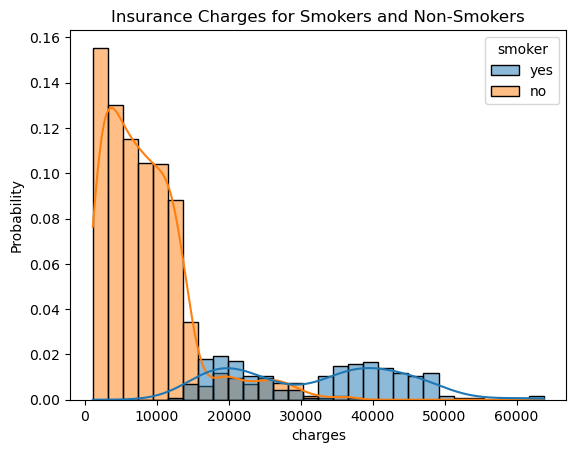

In [13]:
# Plotting a histogram
ax = sns.histplot(x=df['charges'], stat='probability',kde=True, hue=df['smoker'])
ax.set_title("Insurance Charges for Smokers and Non-Smokers");

## Q2. Are men more likely to smoke than women?

### 1. State your Null Hypothesis and Alternative Hypothesis

Null - Males are no more likely or less likely to smoke compared to females.

Alternative - There is a significant difference in the amount of males compared to females when it comes to smoking.

### 2. Select the correct test according to the data type and number of samples

Chi-Squared

### 3. Test the assumptions of your selected test

In [14]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


### 4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [15]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [16]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

### 5. Interpret your p-value and reject or fail to reject your null hypothesis 

Because the p-value is less that the alpha(0.05), we will reject the null hypothesis, there is a difference in the number of male smokers compared to female smokers.

### 6. Show a supporting visualization that helps display the result

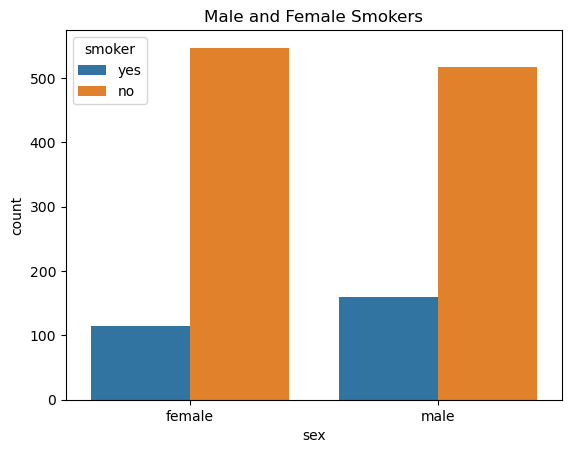

In [17]:
ax = sns.countplot(data=df, x='sex', hue = 'smoker')
ax.set_title("Male and Female Smokers");

## Q3. Do different regions have different charges, on average?

### 1. State your Null Hypothesis and Alternative Hypothesis

Null - There is no difference in charge compared by region

Alternative - There is a difference in charge compared by region.

### 2. Select the correct test according to the data type and number of samples

In [18]:
# Testing for value numbers
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

Due to the number of samples, we will the One Way ANOVA test.

### 3. Test the assumptions of your selected test

In [19]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [20]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [21]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


Because the groups are large enough, we can ignore the failed normalcy.

In [22]:
# Checking equal varience 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

Since there was not equal variance found, we will have to use a different test. In this case, a nonparametric test, Kruskal-Wallis test to be exact.

### 4. Execute the selected test, or the alternative test (if you do not meet the assumptions)

In [23]:
result = stats.kruskal(*groups.values())
result

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

Due to there being a significant result, we shall be performing a Tukey Test in order to see what significant differences there are.

In [24]:
## Saving the values as charges and the labels to the regions
values = df['charges']
labels = df['region']

In [25]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


### 5. Interpret your p-value and reject or fail to reject your null hypothesis 

From the presented data we can reject the null hypothesis that there is no difference in charge compared by region. 

In fact, we can be even more detailed with that there is at least a difference in charge between the regions of southeast and southwest.

### 6. Show a supporting visualization that helps display the result

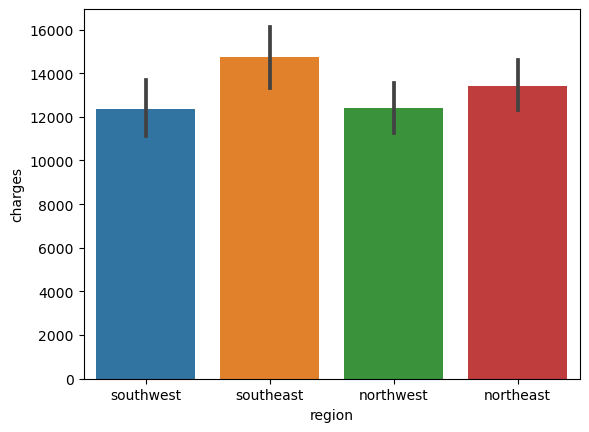

In [26]:
sns.barplot(data=df, y='charges', x='region');